# Data Loading & Preparing

In [2]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

In [3]:
base_rating = pd.read_csv('/content/ua.base', sep='\t', header=None)
test_rating = pd.read_csv('/content/ua.test', sep='\t', header=None)
base_rating.head()

,0,1,2,3
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
col_named = ['User_id', 'Movie_id', 'Rating', 'Timestamp']
base_rating.columns = col_named
test_rating.columns = col_named

In [5]:
base_rating.head()

,User_id,Movie_id,Rating,Timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [6]:
base_rating.describe()

,User_id,Movie_id,Rating,Timestamp
count,90570.000000,90570.000000,90570.000000,9.057000e+04
mean,461.494038,428.104891,3.523827,8.835073e+08
std,266.004364,333.088029,1.126073,5.341684e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,256.000000,174.000000,3.000000,8.794484e+08
50%,442.000000,324.000000,4.000000,8.828143e+08
75%,682.000000,636.000000,4.000000,8.882049e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


# User Item Matrix Creation

In [7]:
n_user_train = base_rating['User_id'].unique().max()
n_movie_train = base_rating['Movie_id'].unique().max()
print(n_user_train, n_movie_train)

943 1682


In [8]:
test_rating.describe()

,User_id,Movie_id,Rating,Timestamp
count,9430.000000,9430.000000,9430.000000,9.430000e+03
mean,472.000000,400.800954,3.587805,8.837354e+08
std,272.234934,306.859789,1.120240,5.360562e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,236.000000,182.000000,3.000000,8.794515e+08
50%,472.000000,303.000000,4.000000,8.833904e+08
75%,708.000000,566.000000,4.000000,8.886378e+08
max,943.000000,1664.000000,5.000000,8.932866e+08


In [9]:
n_user_test = test_rating['User_id'].unique().max()
n_movie_test = test_rating['Movie_id'].unique().max()
print(n_user_test, n_movie_test)

943 1664


In [10]:
train_matrix = np.zeros((n_user_train, n_movie_train))
for line in base_rating.itertuples():
  train_matrix[line[1]-1, line[2]-1] = line[3]

test_matrix = np.zeros((n_user_test, n_movie_test))
for line in test_rating.itertuples():
    test_matrix[line[1]- 1, line[2]- 1] = line[3]

# User-User Collaborative Filtering

In [11]:
user_similarity = pairwise_distances(train_matrix, metric='cosine')
print('Shape: ', user_similarity.shape)
user_similarity

Shape:  (943, 943)


array([[0.        , 0.85324924, 0.9493235 , ..., 0.96129522, 0.8272823 ,
        0.61960392],
       [0.85324924, 0.        , 0.87419215, ..., 0.82629308, 0.82681535,
        0.91905667],
       [0.9493235 , 0.87419215, 0.        , ..., 0.97201154, 0.87518372,
        0.97030738],
       ...,
       [0.96129522, 0.82629308, 0.97201154, ..., 0.        , 0.96004871,
        0.98085615],
       [0.8272823 , 0.82681535, 0.87518372, ..., 0.96004871, 0.        ,
        0.85528944],
       [0.61960392, 0.91905667, 0.97030738, ..., 0.98085615, 0.85528944,
        0.        ]])

Note:
    
    The similarity matrix has a shape of 943 x 943 as expected with each cell corresponding to the similarity between two users.

    Now we will write a prediction function which will predict the values in the user-item matrix. We will only consider the top n users which are similar to a user to make predictions for that user.

    In here, we normalise the ratings of users by subtracting the mean rating of a user from every rating given by the user.

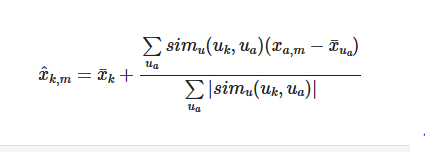

# Prediction Function

In [12]:
def predict_user_user(train_matrix, user_similarity, n):
    # Calculate the mean rating for each user
    mean_user_rating = train_matrix.mean(axis=1)

    # Normalize the ratings by subtracting the mean
    ratings_diff = (train_matrix - mean_user_rating[:, np.newaxis])

    # Initialize the prediction matrix
    pred_matrix = np.zeros_like(train_matrix)

    # Iterate through each user to make predictions
    for user_id in range(train_matrix.shape[0]):
        # Get the indices of the top n most similar users (excluding the user itself)
        # We take the indices of the top n+1 and then exclude the user_id
        similar_users_indices = np.argsort(user_similarity[user_id])[-(n+1):][::-1]
        similar_users_indices = similar_users_indices[similar_users_indices != user_id]

        # Calculate the weighted sum of ratings from similar users
        weighted_sum = user_similarity[user_id, similar_users_indices].dot(ratings_diff[similar_users_indices, :])

        # Calculate the sum of absolute similarities for normalization
        sum_of_similarities = np.abs(user_similarity[user_id, similar_users_indices]).sum()

        # Avoid division by zero
        if sum_of_similarities > 0:
            # Calculate the predicted ratings for the current user
            pred_matrix[user_id, :] = mean_user_rating[user_id] + (weighted_sum / sum_of_similarities)

    return pred_matrix

# Making & Evaluating Predictions

In [13]:
predictions = predict_user_user(train_matrix, user_similarity, 10) + train_matrix.mean(axis= 1)[:, np.newaxis]
print('Predict Shape: ', predictions.shape)
predictions

Predict Shape:  (943, 1682)


array([[ 1.09939506,  1.09939506,  1.09939506, ...,  1.09939506,
         1.09939506,  1.09939506],
       [ 0.18603394,  0.18603394,  0.18603394, ...,  0.18603394,
         0.18603394,  0.18603394],
       [ 1.55410226,  0.0995568 ,  0.0995568 , ...,  0.0995568 ,
         0.0995568 ,  0.0995568 ],
       ...,
       [-0.01070155, -0.01070155, -0.01070155, ..., -0.01070155,
        -0.01070155, -0.01070155],
       [ 0.77391633,  0.31937088,  0.31937088, ...,  0.31937088,
         0.31937088,  0.31937088],
       [ 0.60890715,  0.60890715,  0.60890715, ...,  0.60890715,
         0.60890715,  0.60890715]])

In [14]:
pred_rating = predictions[test_matrix.nonzero()]
test_truth = test_matrix[test_matrix.nonzero()]

In [15]:
math.sqrt(mean_squared_error(pred_rating, test_truth))

3.353370667675524

# Generating User Recommendations

In [16]:
user_id = 88
user_rating = predictions[user_id -1, :]

In [17]:
# This line shows the array of movies that the user hasn't rated yet.
train_indices = np.where(train_matrix[user_id -1, :] == 0)[0]
train_indices

array([   0,    1,    2, ..., 1679, 1680, 1681])

In [18]:
user_recomm = user_rating[train_indices]
user_recomm.shape

(1671,)

In [19]:
print('Recommended Movies for User are: '.format(user_id))

for movie_id in user_recomm.argsort()[-5:][::-1]:
    print(movie_id + 1)

Recommended Movies for User are: 
174
172
50
195
173


# **Bonus Work**

# 1- Singular Value Decomposition (SVD)

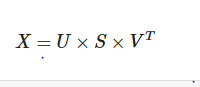

In [20]:
# SVD()

import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [21]:
u, s, vt = svds(train_matrix, k = 20)
u.shape, s.shape, vt.shape

((943, 20), (20,), (20, 1682))

In [22]:
# Converts Singular values into 2D Diagonal Matrix.
diag_matrix = np.diag(s)

# Making and Evaluating Predictions

In [23]:
pred_svd = np.dot(np.dot(u, diag_matrix), vt)
pred_svd.shape

(943, 1682)

In [24]:
pred_rating_svd = pred_svd[test_matrix.nonzero()]
test_truth_svd = test_matrix[test_matrix.nonzero()]

In [25]:
math.sqrt(mean_squared_error(pred_rating_svd, test_truth_svd))

2.8258075694458302

# Generating User Recommendations

In [26]:
user_id = 66
user_rating = pred_svd[user_id -1, :]
train_indices = np.where(train_matrix[user_id -1, :] == 0)[0]
user_recomm = user_rating[train_indices]

In [27]:
print('Movie Recommendation for User ID: '.format(user_id))
for movie_id in user_recomm.argsort()[-5:][::-1]:
    print(movie_id + 1)

Movie Recommendation for User ID: 
174
95
112
266
248


# 2- Item-Item Collaborative Filtering

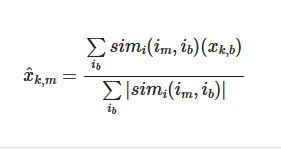

In [28]:
item_similarity = pairwise_distances(train_matrix.T, metric= 'cosine')
item_similarity.shape

(1682, 1682)

# Prediction Function

In [29]:
def predict_item_item(train_matrix, item_similarity, n):
    # Initialize the prediction matrix
    pred_matrix = np.zeros_like(train_matrix)

    # Iterate through each item to make predictions
    for item_id in range(train_matrix.shape[1]):
        # Get the indices of the top n most similar items (excluding the item itself)
        # We take the indices of the top n+1 and then exclude the item_id
        similar_items_indices = np.argsort(item_similarity[item_id])[-(n+1):][::-1]
        similar_items_indices = similar_items_indices[similar_items_indices != item_id]

        # Get the ratings for the current item from users who have rated similar items
        ratings_of_similar_items = train_matrix[:, similar_items_indices]

        # Get the similarity scores for the similar items
        similarity_of_similar_items = item_similarity[item_id, similar_items_indices]

        # Calculate the weighted sum of ratings from similar items
        # We need to handle cases where a user hasn't rated any of the similar items
        weighted_sum = ratings_of_similar_items.dot(similarity_of_similar_items)

        # Calculate the sum of absolute similarities for normalization
        sum_of_similarities = np.abs(similarity_of_similar_items).sum()

        # Avoid division by zero
        if sum_of_similarities > 0:
            # Calculate the predicted ratings for the current item across all users
            pred_matrix[:, item_id] = weighted_sum / sum_of_similarities

    return pred_matrix

#  Making and Evaluating Predictions

In [30]:
predictions_item = predict_item_item(train_matrix, item_similarity, 10)
print('Predict Shape: ', predictions_item.shape)

Predict Shape:  (943, 1682)


In [31]:
pred_rating_item = predictions_item[test_matrix.nonzero()]
test_truth_item = test_matrix[test_matrix.nonzero()]

In [32]:
math.sqrt(mean_squared_error(pred_rating_item, test_truth_item))

3.7530510449090526

# Generating User Recommendation

In [33]:
user_id = 66
user_rating = predictions_item[user_id -1, :]
train_indices = np.where(train_matrix[user_id -1, :] == 0)[0]
user_recomm = user_rating[train_indices]

In [34]:
user_recomm.shape

(1654,)

In [36]:
print('Recommended Movies for User ID: '.format(user_id))
for movie_id in user_recomm.argsort()[-5:][::-1]:
    print(movie_id + 1)

Recommended Movies for User ID: 
824
999
1545
110
1630


*Note: The names of Movies aren't showing coz the dataset doesn't contains any file that has movie names. So we're seeing just their ID's.*